**Demo Backtest: Risk Model Comparison** 

This notebook presents a simple backtest comparing different covariance estimation methods under a risk aversion portfolio optimiser.

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from pypfopt.hierarchical_portfolio import HRPOpt
from src.strategy import strategy
from src.backtest import backtest
from src.volatility_models import arch_wrapper
from src.risk_models import pca_cov

The following cell calls a private function to load the proprietary data. It consists of closing prices of a universe of c. 1000 US equities and 25 simple features derived from well-known sources (e.g. accounting data, momentum) observed over 150 months ending in December 2021. 

In [2]:
from data.load_data import load_data
features, returns = load_data()

Creating the strategies.

In [3]:
# shared optimiser and return model
hrp_optim = lambda expected_returns, expected_covariance : HRPOpt(cov_matrix = pd.DataFrame(expected_covariance)).optimize()
rtn_model = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])

In [4]:
#factor model: sample covariance of factor returns + ARCH(1) idiosyncratic volatility
vol_params = {'mean' : 'Zero', 'lags' : 1, 'vol' : 'ARCH'}
vol_model = arch_wrapper
factor_strat = strategy(return_model = rtn_model, vol_model = vol_model, optim_func = hrp_optim, vol_model_params = vol_params)

In [5]:
#Sample covariance - 12 month rolling window
sample_cov = lambda returns : (returns.unstack().dropna(axis = 1)).cov()
window_size = 12
sample_cov_strat = strategy(return_model = rtn_model, optim_func = hrp_optim, use_factor_risk = False, 
                            cov_calc = sample_cov, cov_lookback = window_size)

In [6]:
#Covariance estimated via PCA: components chosen to retain 90% of variance, 12 month window
target_var = 0.9
pca_calc = lambda x: pca_cov(x, target_var)
pca_strat = strategy(return_model = rtn_model, optim_func = hrp_optim, use_factor_risk = False, 
                     cov_calc = pca_calc, cov_lookback = window_size)

In [7]:
#Volatility forecast scaled PCA covariance: ARCH(1), 90% of variance, 12 month window
scaled_pca_strat = strategy(return_model = rtn_model, optim_func = hrp_optim, use_factor_risk = False, 
                            cov_calc = lambda x: pca_cov(x, n_comps = 0.9), cov_lookback = 12, 
                            vol_model = vol_model, vol_model_params = vol_params)

Running the backtest.

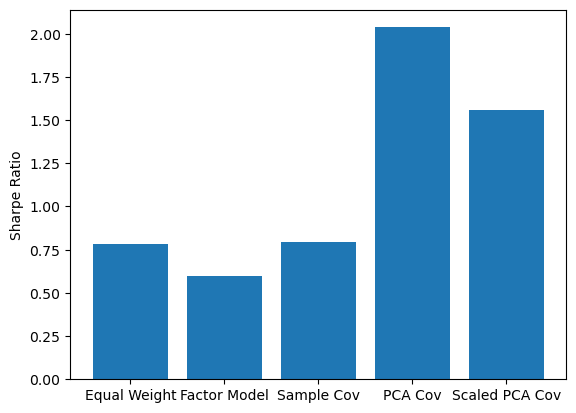

In [8]:
strategy_grid = {'Factor Model': factor_strat, 'Sample Cov' : sample_cov_strat, 'PCA Cov' : pca_strat, 
                'Scaled PCA Cov' : scaled_pca_strat}

test = backtest(strategy_grid)
test.compute_returns(features, returns, burn_in = 12)
test.compute_stat([test.sharpe_ratio, test.sortino_ratio, test.max_drawdown], ['Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown'])
test.plot_stat('Sharpe Ratio')